In [73]:
!pip install aif360
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys 
import os  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
sess = tf.Session()
import aif360.metrics 

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

import aif360.datasets
import aif360.algorithms.preprocessing
import aif360.algorithms.inprocessing
import aif360.algorithms.postprocessing
from IPython.display import Markdown, display
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split


def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [75]:
dataset = pd.read_csv('/content/gdrive/My Drive/Fairness inAI/Ricci.csv')
dataset = dataset.drop(labels='Unnamed: 0', axis= 1)
dataset.head()


,Race,Position,Oral,Written,Combine
0,W,Captain,89.52,95,92.808
1,W,Captain,80.00,95,89.000
2,W,Captain,82.38,87,85.152
3,W,Captain,88.57,76,81.028
4,W,Captain,76.19,84,80.876


In [76]:
dataset.groupby('Race').describe()

Oral                               ... Combine                        
     count       mean        std    min  ...     25%     50%     75%     max
Race                                     ...                                
B     27.0  63.952222  10.974650  45.83  ...  57.662  61.068  72.030  76.600
H     23.0  57.036957  10.990928  40.83  ...  60.078  65.000  69.946  79.676
W     68.0  69.017647  12.039179  44.58  ...  68.015  71.642  78.451  92.808

[3 rows x 24 columns]

In [77]:
dataset.describe()

,Oral,Written,Combine
count,118.000000,118.000000,118.000000
mean,65.523390,71.652542,69.200881
std,12.421927,10.622808,9.387575
min,40.830000,46.000000,45.932000
25%,55.387500,65.000000,60.942000
50%,66.040000,71.500000,69.502000
75%,73.810000,78.500000,75.832000
max,92.080000,95.000000,92.808000


In [78]:
dataset.query('Position == Position.max()')

,Race,Position,Oral,Written,Combine
41,W,Lieutenant,88.75,91,90.100
42,W,Lieutenant,87.50,87,87.200
43,W,Lieutenant,77.50,91,85.600
44,W,Lieutenant,85.00,84,84.400
45,W,Lieutenant,80.00,87,84.200
...,...,...,...,...,...
113,H,Lieutenant,40.83,64,54.732
114,B,Lieutenant,52.08,56,54.432
115,H,Lieutenant,48.33,58,54.132
116,B,Lieutenant,52.92,49,50.568


In [79]:
dataset.groupby(['Position', 'Race']).describe()['Oral']

count       mean        std  ...     50%      75%    max
Position   Race                               ...                        
Captain    B       8.0  65.892500   9.782318  ...  68.095  70.5975  82.38
           H       8.0  63.928750  11.690974  ...  63.810  71.5475  79.05
           W      25.0  72.362000  11.737808  ...  73.810  80.0000  89.52
Lieutenant B      19.0  63.135263  11.592291  ...  60.830  70.0000  92.08
           H      15.0  53.361333   8.937207  ...  51.670  56.8750  70.83
           W      43.0  67.073256  11.914666  ...  68.330  73.9600  88.75

[6 rows x 8 columns]

In [80]:
dataset.groupby(['Position', 'Race'])['Written'].describe()

count       mean        std   min    25%   50%    75%   max
Position   Race                                                             
Captain    B       8.0  62.375000  11.500776  49.0  52.25  63.0  71.00  77.0
           H       8.0  71.625000   8.450486  61.0  65.00  70.5  76.75  84.0
           W      25.0  75.280000   8.928046  58.0  69.00  75.0  81.00  95.0
Lieutenant B      19.0  64.105263  10.213796  46.0  58.00  64.0  69.50  86.0
           H      15.0  70.466667   6.128000  58.0  67.50  71.0  72.50  82.0
           W      43.0  75.023256  10.747067  57.0  66.00  74.0  84.00  95.0

In [81]:
dataset.groupby(['Position', 'Race'])['Combine'].describe()

count       mean       std  ...     50%     75%     max
Position   Race                              ...                        
Captain    B       8.0  63.782000  8.492689  ...  63.900  70.742  74.952
           H       8.0  68.546500  8.701684  ...  67.524  76.615  79.676
           W      25.0  74.112800  8.251842  ...  73.732  78.124  92.808
Lieutenant B      19.0  63.717263  9.076899  ...  61.068  72.482  76.600
           H      15.0  63.624533  5.768875  ...  63.268  68.666  71.200
           W      43.0  71.843256  9.145921  ...  70.732  78.766  90.100

[6 rows x 8 columns]

In [82]:
labels = (dataset.columns.values)
print(labels)
labels = np.reshape(labels, (np.asarray(labels).shape[0],1)).ravel()
print(labels.shape)
np_dataset = dataset.to_numpy()
#print(np_dataset)

['Race' 'Position' 'Oral' 'Written' 'Combine']
(5,)


**Data Preprocessing**

As we loaded the data from a CSV file, we need to do few things:
- **Modify Data** : remove features that should not be used for classification (protected attributes). Look for Nan values.
- Group Processing : We put the privileged-group values to 1 (race : W). All the other values of the attribute Race are set to 0 (race : H, B)
- Value Scaling : We scale the value of the notes between [0,1]

In [83]:
proc_dataset= dataset.replace(['W','B','H','Captain','Lieutenant'],[1,0,0,1,0])
proc_dataset['Oral']= (proc_dataset['Oral']-min(proc_dataset['Oral']))/(max(proc_dataset['Oral'])-min(proc_dataset['Oral']))
proc_dataset['Written']= (proc_dataset['Written']-min(proc_dataset['Written']))/(max(proc_dataset['Written'])-min(proc_dataset['Written']))
proc_dataset['Combine']= (proc_dataset['Combine']-min(proc_dataset['Combine']))/(max(proc_dataset['Combine'])-min(proc_dataset['Combine']))
proc_dataset.head()

,Race,Position,Oral,Written,Combine
0,1,1,0.950049,1.000000,1.000000
1,1,1,0.764293,1.000000,0.918764
2,1,1,0.810732,0.836735,0.836675
3,1,1,0.931512,0.612245,0.748699
4,1,1,0.689951,0.775510,0.745456


In [0]:
sensitive_attribute = 'Race'
privileged_group = [{'Race':1}]
unprivileged_group = [{'Race':0}]

np_proc_dataset = proc_dataset.to_numpy()


Here, I retrieve the labels froms the Ricci dataset, and set the protected attribute to **Race**

In [85]:
protected_attribute= ['Race']
print(labels.tolist())

#print((train.to_numpy()))


['Race', 'Position', 'Oral', 'Written', 'Combine']


**Creation of trainsets, testset, validationset**

We use train_test_split to separate the values to three datasets

In [0]:
#df = aif360.datasets.StructuredDataset(proc_dataset,label_names=labels.tolist(), protected_attribute_names=protected_attribute)

dataset_orig_train, dataset_orig_vt = train_test_split(proc_dataset, test_size=0.3)
dataset_orig_valid, dataset_orig_test = train_test_split(proc_dataset, test_size=0.5)



In [87]:
print(protected_attribute)
print(type(dataset_orig_train[['Combine']]))

['Race']
<class 'pandas.core.frame.DataFrame'>


#Metric for the original data

As the values for the protected attribute Race are binary, we create a BinaryLabelDataset using AIF360. Hence, the protected_attribute is Race. 

# Train set

In [0]:
dataset_orig_train_bin = aif360.datasets.BinaryLabelDataset(favorable_label=1, 
                                 unfavorable_label=0,
                                 df = dataset_orig_train, 
                                 label_names= ['Position'], 
                                 protected_attribute_names=protected_attribute)

dataset_orig_test_bin = aif360.datasets.BinaryLabelDataset(favorable_label=1, 
                                 unfavorable_label=0,
                                 df = dataset_orig_test, 
                                 label_names= ['Position'], 
                                 protected_attribute_names=protected_attribute
                                 )
dataset_orig_valid_bin = aif360.datasets.BinaryLabelDataset(favorable_label=1, 
                                 unfavorable_label=0,
                                 df = dataset_orig_valid, 
                                 label_names= ['Position'], 
                                 protected_attribute_names=protected_attribute)

We can define our metric with a BinaryLabelDatasetMetric ;

In [89]:
metric_orig_train = aif360.metrics.BinaryLabelDatasetMetric(dataset_orig_train_bin, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.030637


Here we can understand that 6% of the privileged group (white race) is getting more positives outcomes in the training dataset. this is unwanted. So we are going to do some mitigation of this bias by reweighing the dataset. 
**Reweighing** transforms the dataset to have more equity between the privileged and unpivileged groups

In [0]:
#!pip install BlackBoxAuditing
#from aif360.algorithms.preprocessing import DisparateImpactRemover
#import BlackBoxAuditing
#reweigh = DisparateImpactRemover(1.0,sensitive_attribute='Race')
#dataset_transf_train = reweigh.fit_transform(dataset_orig_test_bin)
#dataset_transf_train = dataset_orig_train_bin.align_datasets(dataset_transf_train)

In [0]:
reweigh = Reweighing(unprivileged_groups=unprivileged_group,
                     privileged_groups=privileged_group)

dataset_transf_train = reweigh.fit_transform(dataset_orig_test_bin)
dataset_transf_train = dataset_orig_train_bin.align_datasets(dataset_transf_train)

In [92]:
metric_transf_train = aif360.metrics.BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


We can see that with the reweighing the mean outcome between the prvileged and the unprivileged was reduced to 0. So the dataset has now more equity between the privileged and unprivileged group.



In [0]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < np.abs(metric_orig_train.mean_difference())

# Data Loading and test with the original test

Now we are going to load test data

In [94]:
dataset_orig_test = dataset_transf_train.align_datasets(dataset_orig_test_bin)

metric_orig_test = aif360.metrics.BinaryLabelDatasetMetric(dataset_orig_test_bin, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)

display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.031579


In [95]:
dataset_transf_test = reweigh.transform(dataset_orig_test_bin)
dataset_transf_test= dataset_orig_test_bin.align_datasets(dataset_transf_train)

metric_transf_test = aif360.metrics.BinaryLabelDatasetMetric(dataset_transf_test, 
                                         unprivileged_groups=unprivileged_group,
                                         privileged_groups=privileged_group)

display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())


#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [0]:
### Testing 
assert np.abs(metric_transf_test.mean_difference()) < np.abs(metric_orig_test.mean_difference())

# Let's Train a Classifier on the original data 



# Logistic Regression


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train_bin.features)
y_train = dataset_orig_train_bin.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train_bin.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train_bin.copy()
dataset_orig_train_pred.labels = y_train_pred

In [0]:
dataset_orig_valid_pred = dataset_orig_valid_bin.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test_bin.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [99]:
from aif360.metrics import ClassificationMetric

num_thresh = 150
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid_bin,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_group,
                                             privileged_groups=privileged_group)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]





print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.7615
Optimal classification threshold (no fairness constraints) = 0.2928


# Prediction and fairness metric from original test set

In [100]:
from tqdm import tqdm
from collections import OrderedDict


display(Markdown("#### Predictions from original testing data"))

bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

display(Markdown("#### Testing set"))
display(Markdown("##### Raw predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_orig_test_bin, dataset_orig_test_pred, 
                                       unprivileged_group, privileged_group, disp=disp)
    
    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])
    #print(bal_acc_arr_orig)
   

#### Predictions from original testing data

#### Testing set

##### Raw predictions - No fairness constraints

  0%|          | 0/150 [00:00<?, ?it/s]

Balanced accuracy = 0.5562

 43%|████▎     | 65/150 [00:00<00:00, 648.02it/s]


Statistical parity difference = -0.0711
Disparate impact = 0.8907
Average odds difference = -0.0491
Equal opportunity difference = 0.0268
Theil index = 0.1859


/usr/local/lib/python3.6/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
/usr/local/lib/python3.6/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 150/150 [00:00<00:00, 653.87it/s]


In [101]:
print(max(bal_acc_arr_orig))
print(max(class_thresh_arr))
print(np.abs(1.0-np.array(disp_imp_arr_orig)))


0.5785024154589372
0.99
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.02834008 0.02834008 0.02834008 0.02834008
 0.02834008 0.00277008 0.02418208 0.05263158 0.08270677 0.08452951
 0.02073365 0.07894737 0.21052632 0.18505942 0.15789474 0.15789474
 0.12885662 0.12885662 0.12885662 0.12885662 0.12885662 0.09774436
 0.09774436 0.10931174 0.07368421 0.15789474 0.24210526 0.24210526
 0.24210526 0.24210526 0.24210526 0.24210526 0.32631579 0.32631579
 0.38596491 0.38596491 0.38596491 0.38596491 0.26315789 0.26315789
 0.22437673 0.18128655 0.13312693 0.15789474 0.09774436 0.09774436
 0.02834008 0.12280702 0.12280702 0.12280702 0.0430622  0.0430622
 0.23444976 0.23444976 0.23444976 0.06432749 0.05263158 0.05263158
 0.05263158 0.05263158 0.09774436 0.09774436 0.09774436 0.05263158
 0.05263158 0.29824561 0.29824561 0.15789474 0.05263158 0.40350

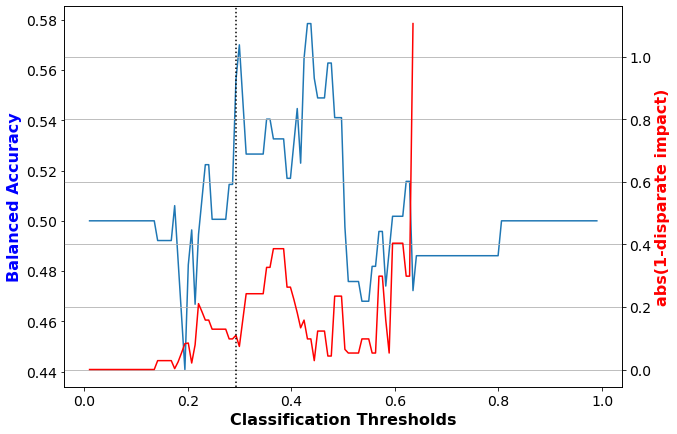

In [102]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_orig = np.abs(1.0-np.array(disp_imp_arr_orig))[best_ind]

abs(1-disparate impact) has to be close to 0 for the classifier to be fair. The maximum value is here 1.6.
The Balanced Accuracy is 0.70. Classification Threshold = 0.59


# With Transformed Data

# Test Set

In [0]:
dataset_transf_test = reweigh.fit_transform(dataset_orig_test_bin)
dataset_transf_test = dataset_orig_train_bin.align_datasets(dataset_transf_test)

In [0]:
from sklearn.ensemble import RandomForestClassifier

scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()

lmod.fit(X_train, y_train)

y_train_pred = lmod.predict(X_train)


dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred

In [0]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)
X_test = scale_transf.transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [106]:
display(Markdown("#### Predictions from transformed testing data"))

bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

display(Markdown("#### Testing set"))
display(Markdown("##### Transformed predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_transf_test, dataset_transf_test_pred, 
                                       unprivileged_group, privileged_group, disp=disp)
    
    bal_acc_arr_transf.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_bef["Disparate impact"])

#### Predictions from transformed testing data

#### Testing set

##### Transformed predictions - No fairness constraints

 47%|████▋     | 70/150 [00:00<00:00, 699.86it/s]/usr/local/lib/python3.6/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 150/150 [00:00<00:00, 686.18it/s]

Balanced accuracy = 0.5000
Statistical parity difference = 0.0000
Disparate impact = 1.0000
Average odds difference = 0.0000
Equal opportunity difference = 0.0000
Theil index = 0.0490


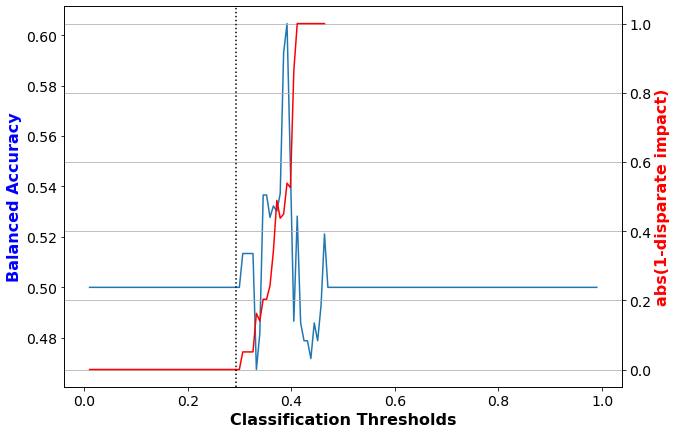

In [107]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_transf = np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]

In [0]:
### testing
assert disp_imp_at_best_bal_acc_transf < disp_imp_at_best_bal_acc_orig

# Random Forest

Best balanced accuracy (no fairness constraints) = 0.7236
Optimal classification threshold (no fairness constraints) = 0.3849


#### Predictions from original testing data

#### Testing set

##### Raw predictions - No fairness constraints

  0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
 49%|████▉     | 74/150 [00:00<00:00, 736.81it/s]

Balanced accuracy = 0.5386
Statistical parity difference = -0.3118
Disparate impact = 0.4577
Average odds difference = -0.3557
Equal opportunity difference = -0.5446
Theil index = 0.2652


100%|██████████| 150/150 [00:00<00:00, 648.71it/s]


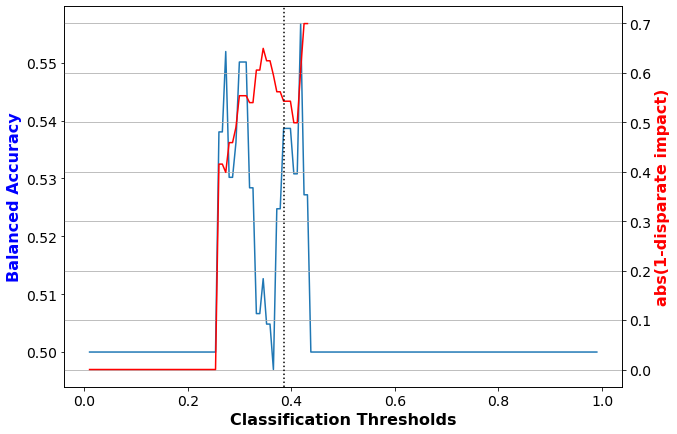

In [109]:
from sklearn.pipeline import Pipeline

rf = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
X_train = scale_orig.fit_transform(dataset_orig_train_bin.features)
y_train = dataset_orig_train_bin.labels.ravel()
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)

# positive class index
pos_ind = np.where(rf.classes_ == dataset_orig_train_bin.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train_bin.copy()
dataset_orig_train_pred.labels = y_train_pred

dataset_orig_valid_pred = dataset_orig_valid_bin.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = rf.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test_bin.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = rf.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

from aif360.metrics import ClassificationMetric

num_thresh = 150
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid_bin,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_group,
                                             privileged_groups=privileged_group)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

from tqdm import tqdm
from collections import OrderedDict


display(Markdown("#### Predictions from original testing data"))

bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

display(Markdown("#### Testing set"))
display(Markdown("##### Raw predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_orig_test_bin, dataset_orig_test_pred, 
                                       unprivileged_group, privileged_group, disp=disp)
    
    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])
    #print(bal_acc_arr_orig)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_orig = np.abs(1.0-np.array(disp_imp_arr_orig))[best_ind]




#### Predictions from transformed testing data

#### Testing set

##### Transformed predictions - No fairness constraints

  0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 150/150 [00:00<00:00, 715.73it/s]

Balanced accuracy = 0.5000
Statistical parity difference = 0.0000
Disparate impact = 1.0000
Average odds difference = 0.0000
Equal opportunity difference = 0.0000
Theil index = 0.0490


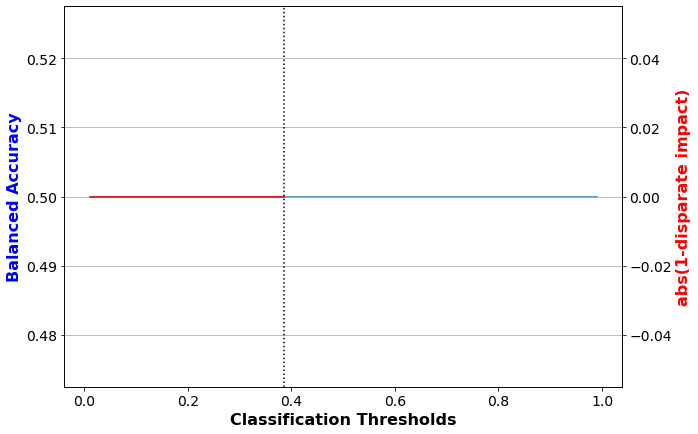

In [110]:
# dataset_transf_test = reweigh.fit_transform(dataset_orig_test_bin)
# dataset_transf_test = dataset_orig_train_bin.align_datasets(dataset_transf_test)


# rf = make_pipeline(StandardScaler(),
#                     RandomForestClassifier(n_estimators=500, min_samples_leaf=25))

X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()


rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)


dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred

dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)
X_test = scale_transf.transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = rf.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

display(Markdown("#### Predictions from transformed testing data"))

bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

display(Markdown("#### Testing set"))
display(Markdown("##### Transformed predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False
        
    metric_test_bef = compute_metrics(dataset_transf_test, dataset_transf_test_pred, 
                                       unprivileged_group, privileged_group, disp=disp)
    
    bal_acc_arr_transf.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_bef["Disparate impact"])

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_transf = np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]

In [0]:
### testing
assert disp_imp_at_best_bal_acc_transf < disp_imp_at_best_bal_acc_orig